In [1]:
import keras

Using TensorFlow backend.


In [0]:
from keras.applications import MobileNetV2
mobile = MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')

In [3]:
mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
for layer in mobile.layers:
  layer.trainable = False

In [0]:
from keras.layers import Dense , AveragePooling2D , Dropout ,Flatten , MaxPooling2D
from keras.models import Model

In [0]:
op_layer = mobile.output
op_layer = MaxPooling2D(pool_size=(6,6))(op_layer)
op_layer = Flatten()(op_layer)
op_layer = Dense(128,activation='relu')(op_layer)
op_layer = Dropout((0.5))(op_layer)
op_layer = Dense(2,activation= 'softmax')(op_layer)

In [0]:
model = Model(inputs = mobile.input , outputs = op_layer)
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/mask_model')

In [0]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from keras import layers
from keras import Model
import random
import cv2
from keras.applications.mobilenet_v2 import preprocess_input

In [0]:
import os
import zipfile

local_zip = '/content/drive/My Drive/Colab Notebooks/dataset.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
dataset = '/tmp/dataset'

In [0]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
EPOCHS = 50
BS = 32

In [19]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset))
random.seed(42)
random.shuffle(imagePaths)
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:

	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (150x150) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)/255.
	
 
	#image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)


[INFO] loading images...


In [0]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
label_value = to_categorical(labels)

In [0]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, label_value,
	test_size=0.20, stratify=labels, random_state=42,shuffle = True)

In [0]:
aug_train = ImageDataGenerator(rescale= 1.0/255.,
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

aug_test  = ImageDataGenerator(rescale= 1.0/255.)

In [23]:
hist = model.fit_generator(steps_per_epoch=len(trainX)//BS,
                           generator=aug_train.flow(trainX, trainY, batch_size=BS),
                           validation_data= (testX, testY),
                           validation_steps=len(testX)//BS,
                           epochs=EPOCHS)

Epoch 1/50
30/30 [==============================] - 12s 384ms/step - loss: 0.4724 - acc: 0.7638 - val_loss: 0.3232 - val_acc: 0.8992
Epoch 2/50
30/30 [==============================] - 11s 369ms/step - loss: 0.4566 - acc: 0.7889 - val_loss: 0.2828 - val_acc: 0.9395
Epoch 3/50
30/30 [==============================] - 11s 362ms/step - loss: 0.3999 - acc: 0.8109 - val_loss: 0.2720 - val_acc: 0.9032
Epoch 4/50
30/30 [==============================] - 11s 360ms/step - loss: 0.4151 - acc: 0.8015 - val_loss: 0.2307 - val_acc: 0.9516
Epoch 5/50
30/30 [==============================] - 11s 351ms/step - loss: 0.3738 - acc: 0.8380 - val_loss: 0.1853 - val_acc: 0.9476
Epoch 6/50
30/30 [==============================] - 11s 357ms/step - loss: 0.3426 - acc: 0.8527 - val_loss: 0.1777 - val_acc: 0.9435
Epoch 7/50
30/30 [==============================] - 11s 359ms/step - loss: 0.3262 - acc: 0.8610 - val_loss: 0.1676 - val_acc: 0.9556
Epoch 8/50
30/30 [==============================] - 11s 359ms/step - 

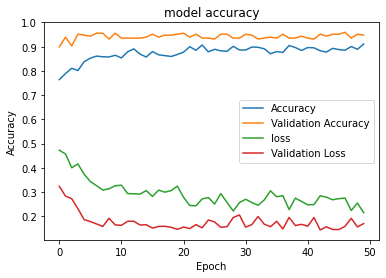

In [24]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [0]:
model.save_weights('/content/drive/My Drive/Colab Notebooks/mask_model_weights.h5')

In [0]:
#from keras.models import load_model
#model = load_model('/content/drive/My Drive/Colab Notebooks/mask_model',custom_objects=None, compile=True)

In [27]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(testX)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(testY,axis=1)
print(confusion_matrix(y_true,y_p))

[[134   5]
 [  8 101]]
